In [12]:
#Code1 - getting coordinates of the contacts in filtered cells
import pandas as pd
import glob
files = glob.glob('1CDU/*/adj')

coord_df = pd.read_csv('GATC.fends', sep="\t")
coord_df['fend1'] = coord_df['fend']
out = open('1CDUinfo(%)filt.txt', 'a')
out.write('file' + '\t' + 'short_range_contacts' + '\t' + 'mitotic_contacts' + '\t' + 'trans_contacts' + '\n')

for file in files[:101]:
    print(file)
    read_df = pd.read_csv(file, sep="\t")
    s1 = pd.merge(read_df, coord_df, on='fend1', how='left')
    coord_df['fend2'] = coord_df['fend']    
    combo_df = pd.merge(s1, coord_df, on='fend2', how='left')
    del combo_df['fend1_x'], combo_df['fend2'], combo_df['fend1_y'], coord_df['fend2']
    
    all_cont = len(combo_df)
    #filter1
    if (all_cont > 20000) and (all_cont < 700000):
        trans_contacts = len(combo_df[combo_df["chr_x"] != combo_df["chr_y"]]) * 100 / all_cont
        #filter2
        if trans_contacts <= 15:
            combo_df = combo_df[combo_df["chr_x"] == combo_df["chr_y"]]
            combo_df["lengths"] = abs(combo_df["coord_x"] - combo_df["coord_y"]) + 1
            super_short = len(combo_df[combo_df["lengths"] <= 1000])  * 100 / all_cont
            #filter3
            if super_short <= 55:
                short_range_contacts = len(combo_df[combo_df["lengths"] <= 2000000])  * 100 / all_cont
                mitotic_contacts = len(combo_df[(combo_df["lengths"] < 12000000) & (combo_df["lengths"] > 2000000)])  * 100 / all_cont

                combo_df.to_csv(file + '_filt.txt', sep="\t")
                out.write(file +'\t'+ str(short_range_contacts) +'\t'+ str(mitotic_contacts) +'\t'+ str(trans_contacts) + '\n') 
out.close()

In [45]:
#Code 2 - getting cells' phase
#output: ARCHphase(%).txt; in every cell-folder: adj_filt_bins.txt - number of contacts in each bin; in archive: file "phase.txt"
import pandas as pd
import glob
files = glob.glob('1CDES/*/adj_filt.txt')

out = open('1CDESphase(%).txt', 'a')
out.write('file' + '\t' + '% near' + '\t' + '% mitotic'+ '\t' + 'farAvgDist' + '\t' + 'cell phase'  + '\n')

bns = [1000* 2 ** (0.125 * n) for n in range(144)]
bins = dict()
for i in range(144):
    bins[i] = bns[i]
inbins = dict()
for file in files:
    read_df = pd.read_csv(file, sep="\t")
    inbins[0] = len(read_df[(read_df['lengths'] < bins[0])])
    for i in range(1, 144):
        inbins[i] = len(read_df[(read_df['lengths'] < bins[i]) & (read_df['lengths'] > bins[i-1])])
        
    Bins = pd.DataFrame(inbins, index = [1])
    Bins.to_csv(file.split('.txt')[0] + '_bins' + '.txt', sep = '\t')
    
    valid_bins = sum(inbins[i] for i in range(38, 144))
    near = sum(inbins[i] for i in range(38, 90)) * 100 / valid_bins 
    mitotic = sum(inbins[i] for i in range(90, 110)) * 100 / valid_bins
    if near > 78.5:
        phase = 'Mid-S to G2'
    elif (near <= 50) and (mitotic >= 30):
        phase = 'Post-M'
    elif near <= 63:
        phase = 'G1'
    elif (near > 63) and (near <=78.5):
        phase = 'Early to mid-S'
    elif (near > 50) and (near + 1.8 * mitotic > 100):
        phase = 'Pre-M'
    
    f = read_df[read_df['lengths'] >= bins[98]]
    farA = f['lengths'].mean()

    out.write(file + '\t' + str(near) + '\t' + str(mitotic) + '\t' + str(farA) + '\t' + phase + '\n') 
out.close()

#different phases - different files
phase_df = pd.read_csv('1CDESphase(%).txt', sep="\t")
grouped = phase_df.groupby('cell phase')
for name, group in grouped:
    group.to_csv('1CDES/' + name + '.txt', sep = '\t')

KeyboardInterrupt: 

In [1]:
#Code 3 - join files with phases in archives
#output: "<phase>.txt" и "<phase>_sorted.txt for Post-M, G1, Pre-M"
import pandas as pd
import glob

phases = ['Post-M', 'G1', 'Pre-M', 'Early to mid-S','Mid-S to G2']
#all to 1 file
def phase_to_file(string):
    files = glob.glob('*/' + string + '.txt')
    result = pd.read_csv(files[0], sep="\t")
    for file in files[1:]:
        result = pd.concat([result, pd.read_csv(file, sep="\t")])
    return result

for i in phases:
    read = phase_to_file(i)
    del read['Unnamed: 0']
    read.to_csv(i + '.txt', sep = '\t')

#sorting
def sort(name):
    read = pd.read_csv(name + '.txt', sep="\t")
    if name == 'Post-M':
        read.sort_values(by = '% mitotic', inplace = True, ascending = False)
    elif name == 'Pre-M':
        read.sort_values(by = '% mitotic', inplace = True)
    elif name == 'G1':
        n_std = read['% near'].std()
        n_mean = read['% near'].mean()
        read['n_score'] = (read['% near'] - n_mean) / n_std
        
        far_std = read['farAvgDist'].std()
        far_mean = read['farAvgDist'].mean()
        read['far_score'] = (read['farAvgDist'] - far_mean) / far_std
        
        read['n_score + far_score'] = read['far_score'] + read['n_score']
        read.sort_values(by = 'n_score + far_score', inplace = True)
    del read['Unnamed: 0']
    return read.to_csv(name + '_sorted.txt', sep="\t")

for i in phases[:3]:
    sort(i)

KeyboardInterrupt: 

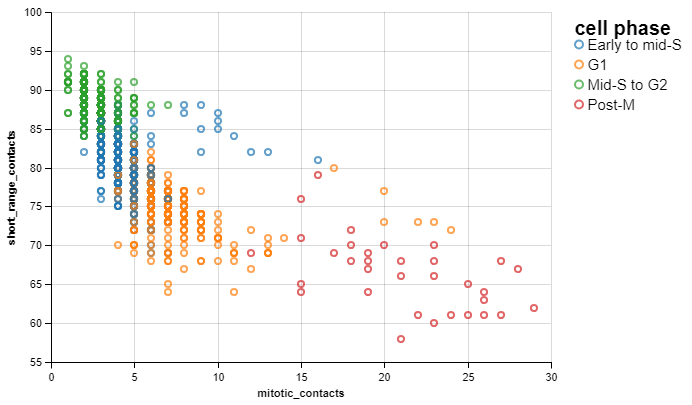

In [70]:
#Visualisation 1e
import altair as alt
import pandas as pd

arch = ['1CDX4', '1CDES', '1CDU', '1CDX3', '1CDX2', '1CDX1']

for file in arch:
    info = pd.read_csv(file + '/' + file +'info(%25)filt.txt', sep="\t")
    phase = pd.read_csv(file + '/' + file +'phase(%25).txt', sep="\t")
    phase['file'] = phase['file'].str.replace('_filt.txt', '')
    withphase_df = pd.merge(info, phase, on='file', how='left')
    withphase_df.to_csv(file + 'info_phase.txt', sep='\t')

for file in arch:
    file = file + 'info_phase.txt'
    result = pd.read_csv(file, sep="\t")

def info_phase_to_file(arch):
    files = [file + 'info_phase.txt' for file in arch]
    result = pd.read_csv(files[0], sep="\t")
    for file in files[1:]:
        result = pd.concat([result, pd.read_csv(file, sep="\t")])
    return result
info_phase_to_file(arch).to_csv('info_phase.txt', sep='\t')

info_phase = pd.read_csv('info_phase.txt', sep="\t")
alt.Chart(info_phase).configure_legend(labelFontSize = 15, titleFontSize=20).mark_point().encode(
 alt.Y('short_range_contacts', scale=alt.Scale(domain=(55, 100))),
 x='mitotic_contacts',
 color='cell phase')

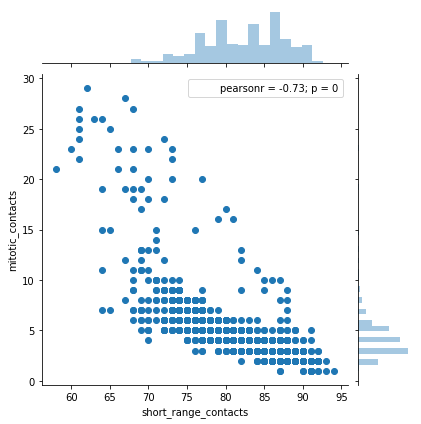

In [71]:
%matplotlib inline
import pandas as pd
import seaborn as sns
info_phase = pd.read_csv('info_phase.txt', sep="\t")
sns.jointplot("short_range_contacts", "mitotic_contacts", data=info_phase, kind="scatter") 